# Sixth homework for computational mathematics course

In [2]:
import numpy as np
import pylab as plt
import pandas as pd
from scipy.optimize import minimize

from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, SGDRegressor

## Exercise 1

$$
\frac{\partial log(P)}{\partial \sigma} = \sum_i \frac{\partial log(p_i)}{\partial \sigma} = \sum_i (\frac{(x_i-\mu)^2}{\sigma^3} - \frac{1}{\sigma}) = 0
$$
$$
\frac{\partial log(P)}{\partial \mu} = \sum_i \frac{\partial log(p_i)}{\partial \mu} = \sum_i \frac{x_i-\mu}{\sigma^2} = 0
$$

$$
\mu = \frac{\sum_i x_i}{N}
$$

$$
\sigma = \sqrt{\frac{\sum_i (x_i - \mu)^2}{N}}
$$

## Exercise 2

$$
P(\lambda|m) = \frac{P_{\lambda}(m)\cdot P(\lambda)}{\int P_{\lambda'}(m)\cdot P(\lambda')d\lambda'} = \frac{\frac{\lambda^m}{m!}e^{-\lambda}}{\int\frac{\lambda^m}{m!}e^{-\lambda}d\lambda'} = \frac{\lambda^me^{-\lambda}}{\Gamma(m+1)} = \frac{\lambda^me^{-\lambda}}{m!}
$$
$$
P(\lambda|m, m') = \frac{P_{\lambda}(m)\cdot P_{\lambda}(m')\cdot P(\lambda)}{\int P_{\lambda'}(m)\cdot P_{\lambda'}(m')\cdot P(\lambda')d\lambda'} = \frac{\frac{\lambda^{(m+m')}}{m!\cdot m'!}e^{-2\lambda}}{\int\frac{\lambda^{(m+m')}}{m!\cdot m'!}e^{-2\lambda}d\lambda'} =  2^{(m+m')}\frac{\lambda^{(m+m')}e^{-2\lambda}}{(m+m')!}
$$

## Exercise 3

A - Petya is sick; B - test is positive:
$$
P(A|B) = \frac{P(B|A)\cdot P(A)}{P(B|A)\cdot P(A) + P(B|!A)\cdot P(!A)} = \frac{0.99\cdot10^{-5}}{0.99\cdot10^{-5} + 0.01\cdot(1-10^{-5})} = 0.1\%
$$

## Exercise 4

$$
P(A|x_1) = \frac{P_{A}(x_1)\cdot P(A)}{\int P_{A'}(x_1)\cdot P(A')dA'} = \frac{e^{-\frac{x_1^TAx_1}{2}}P(A')}{\int e^{-\frac{x_1^TA'x_1}{2}}\cdot P(A')dA'} = \frac{e^{-\frac{x_1^TAx_1}{2}}}{\int e^{-\frac{x_1^TA'x_1}{2}}\cdot dA'} = \frac{e^{-\frac{x_1^TAx_1}{2}}}{N\int e^{-\frac{\xi_1(x_1^1)^2+...+\xi_N(x_1^N)^2}{2}}\cdot d\xi_1...d\xi_N} = \frac{e^{-\frac{x_1^TAx_1}{2}}\prod_{i=1}^N(x_1^i)^2}{N\cdot2^N}
$$
$$
P(x|x_1) = \int P(A'|x_1)P(x|A')dA' = \int \frac{e^{-\frac{x^TAx}{2}}e^{-\frac{x_1^TAx_1}{2}}\prod_{i=1}^N(x_1^i)^2}{N\cdot Z\cdot2^N}dA' = \frac{\prod_{i=1}^N(x_1^i)^2}{Z\cdot2^N}\int e^{-\frac{\xi_1[(x_1^1)^2 + (x^1)^2]+...+\xi_N[(x_1^N)^2 + (x^N)^2]}{2}}d\xi_1...d\xi_N = \frac{\prod_{i=1}^N(x_1^i)^2}{Z\prod_{i=1}^N[(x_1^i)^2 + (x^i)^2]}
$$

## Exercise 5

In [10]:
theta = 1.24

X = np.linspace(0, 3, 1000).reshape(-1, 1)
Y = np.sin(theta*X)

In [13]:
def cross_val(cv, alphas, steps, X, Y):
    best = []
    
    gd_mse = pd.DataFrame(columns=['alpha', 'step', 'mse', 'theta'])
    
    rs = ShuffleSplit(n_splits=cv, random_state=45)
    for alpha in alphas:
        for step in steps:
            errors = []
            ress = []
            for Xtest_index in rs.split(X):
                X_train, X_test = X[Xtest_index[0]], X[Xtest_index[1]]
                y_train, y_test = Y[Xtest_index[0]], Y[Xtest_index[1]]
                
                fun = lambda theta: step*mse(y_train, np.sin(theta*X_train), squared=False) + step*alpha*np.abs(theta)
                res = minimize(fun, 1, method='BFGS')
                errors.append(mse(y_test, np.sin(res.x*X_test), squared=False))
                ress.append(res.x)
            new_row = pd.Series({'alpha': alpha, 'step': step, 'mse': min(errors), 
                                 'theta': np.array(ress)[np.where(errors==min(errors))]})
            gd_mse = pd.concat([gd_mse, new_row.to_frame().T], ignore_index=True)
    gd_mse = gd_mse.sort_values(by=['mse'], ascending=True, ignore_index=True)
    return gd_mse.iloc[0]           

In [14]:
cv = 3
alphas = np.linspace(1e-5, 1e-3, 5)
steps = np.linspace(1e-3, 1e-1, 5)
cross_val(cv, alphas, steps, X, Y)

alpha                  0.000258
step                     0.0505
mse                         0.0
theta    [[1.2399999981798788]]
Name: 0, dtype: object

## Exercise 6

In [4]:
df = pd.read_csv('./Steels_kaggle.csv')

X = df[[' C', ' Si', ' Mn', ' P', ' S', ' Ni', ' Cr', ' Mo',
       ' Cu', 'V', ' Al', ' N', ' Temperature (°C)']]
Y = df[' 0.2% Proof Stress (MPa)']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

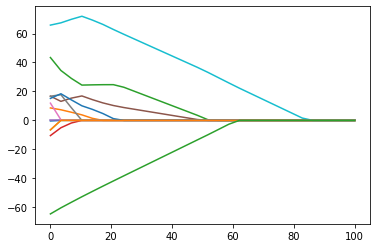

In [6]:
alphas = np.linspace(1e-1, 100, 30)

coefs = []

for alpha in alphas:
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
coefs = np.array(coefs).T

for line in coefs:
    plt.plot(alphas, line)

plt.show()

## Exercise 7

$$
|| y - Xw||_2 \rightarrow min
$$
$$
s.t. ||w||_1 \leq C
$$
Lagrange multipliers method:
$$
L(w, \lambda) = ||y - Xw||_2 - \lambda(C - ||w||_1)
$$
The original problem is dual to the following problem:
$$
g(\lambda) = \max_{\lambda > 0} \left[\min_{\omega}\left(||y - Xw||_2 + \lambda ||w||_1\right) - \lambda C\right]
$$
which is equivalent to
$$
\max_{\lambda > 0}\min_{\omega}\left(||y - Xw||_2 + \lambda ||w||_1 - \lambda C\right)
$$
which is equivalent to
$$
\min_{\omega}\max_{\lambda > 0}\left(||y - Xw||_2 + \lambda ||w||_1 - \lambda C\right)
$$
Finally, for some lambda, the task turned into
$$
\min_{\omega}\left(||y - Xw||_2 + \lambda ||w||_1 - \lambda C\right)
$$
which is equivalent to
$$
\min_{\omega}\left(||y - Xw||_2 + \lambda ||w||_1\right)
$$